<a href="https://colab.research.google.com/github/josh-millar/josh-millar/blob/main/7001_2022_23_Lab_3_Text_Classification_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3 - Neural Network Classifier Using Simple Word Embeddings



---















In this session, we demonstrate how to solve a text classification task using different neural classifiers. We will also experiment with different ways to use word embeddings for classification.

We will use IMDB Large Movie Review Dataset to train a binary classification model, able to predict whether a review is positive or negative. First, our network takes one-hot word vectors as input, averages them to make one vector and trains a 
fully-connected layer to predict the output. In the second part, we replace the one-hot vectors with different word embeddings and add a layer to see how much that improves the performance. We will finally use CNNs to address the problem.

We are going to use Keras Sequential API in this session. The Sequential API allows you to build models layer-by-layer.

In [1]:
import tensorflow.keras as tk
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
from keras.utils import pad_sequences

import matplotlib.pyplot as plt


### Downloading data

The dataset we will be using is the IMDB Large Movie Review Dataset, which consists of 50,000 labeled movie reviews. These are split into 25,000 reviews for training and 25,000 reviews for testing. The  dataset contains an even number of positive and negative reviews, so randomly guessing yields 50% accuracy. The data is preprocessed. For text classification, we usually limit the size of the vocabulary to stop the data from becoming too sparse, creating possible overfitting. We hence keep the top 10,000 most frequently occurring words in the training data.


In [2]:
imdb = tk.datasets.imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000)

17464789/17464789 [==============================] - 2s 0us/step


We now can start look into the data, let’s first see the length:

In [3]:
print("Training entries: {}, labels: {}".format(len(X_train), len(y_train)))

Training entries: 25000, labels: 25000


The  reviews have been converted to integers and each integer represents a  word in a dictionary. 

In [4]:
 X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

We can convert integers back to words by querying a dictionary object that contains the integer to string mapping:

In [5]:
word_index = imdb.get_word_index()

1641221/1641221 [==============================] - 0s 0us/step


Index 1 represents the beginning of the sentence and the index 2 is assigned to all unknown tokens. Index 0 will be used for padding.

In [6]:
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<UNUSED>"] = 3

To reverse key and values in a dictionary:

In [7]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

To view a word:

In [8]:
reverse_word_index[25]

'you'

And to recreate the whole sentence from our training data we define decode_review:


In [9]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [10]:
decode_review(X_train[10])

"<START> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and <UNK> romance <UNK> on to the scene <UNK> <UNK> the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made <UNK> was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is <UNK> by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named <UNK> sent to prison for fraud he is put in a cell with three others the quietly insane <UNK> body building <UNK> marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old <UNK> after <UNK> part of it they soon realise its magical powers and realise they may be able to use it

### Creating One-hot word vectors

It is  common to use one-hot representation as input in NLP tasks. In Keras, the Embedding layer takes an index as an input and convert it to one-hot vector with the length of the vocabulary size. Then it multiplies these vectors by the embedding matrix to get relevant vectors. But there is no way to get a one-hot vector as the output of a layer in Keras. To solve this we use the Lambda() layer and a function that creates the one-hot layer. 

In [11]:
def OneHot(input_dim=None, input_length=None):
    
    if input_dim is None or input_length is None:
        raise TypeError("input_dim or input_length is not set")

    
    def _one_hot(x, num_classes):
        return K.one_hot(K.cast(x, 'uint8'),
                          num_classes=num_classes)

    return Lambda(_one_hot,
                  arguments={'num_classes': input_dim},
                  input_shape=(input_length,))

input_dim refers to the length of the one-hot vector and input_length refers to the length of the input sequence. Since the input to K.one_hot should be an integer tensor, we cast x to int (Keras passes around float tensors by default).



In most cases, each text sequence has a different length in words. Hence, we fill sequences with a pad token (0) accordingly. This special token is then masked not to be accounted for in averaging, loss calculation etc. We set the maximum length to 256.

### Preparing input data

In [12]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 256

X_train_enc = pad_sequences(X_train, value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

X_test_enc = pad_sequences(X_test, value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

And to view a padded review:

In [13]:
print(X_train_enc[1])
print('\nLength: ',len(X_train_enc))

[   1  194 1153  194 8255   78  228    5    6 1463 4369 5012  134   26
    4  715    8  118 1634   14  394   20   13  119  954  189  102    5
  207  110 3103   21   14   69  188    8   30   23    7    4  249  126
   93    4  114    9 2300 1523    5  647    4  116    9   35 8163    4
  229    9  340 1322    4  118    9    4  130 4901   19    4 1002    5
   89   29  952   46   37    4  455    9   45   43   38 1543 1905  398
    4 1649   26 6853    5  163   11 3215    2    4 1153    9  194  775
    7 8255    2  349 2637  148  605    2 8003   15  123  125   68    2
 6853   15  349  165 4362   98    5    4  228    9   43    2 1157   15
  299  120    5  120  174   11  220  175  136   50    9 4373  228 8255
    5    2  656  245 2350    5    4 9837  131  152  491   18    2   32
 7464 1212   14    9    6  371   78   22  625   64 1382    9    8  168
  145   23    4 1690   15   16    4 1355    5   28    6   52  154  462
   33   89   78  285   16  145   95    0    0    0    0    0    0    0
    0 

Now we will build our neural network model. We  are going to have a hidden layer with 16 hidden units. 

First, we want to transform each index to an embedded vector and then average all vectors to a single one. It has been shown that such an unweighted average of word vectors outperforms more complex networks (http://anthology.aclweb.org/P/P15/P15-1162.pdf)

To average we need to ignore padded zeros:

In [14]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


#Model 1: Neural network model using one-hot vectors

The first layer is a one-hot layer. The second layer computes average of all word vectors in a sentence without considering padding. The output vector is then piped through a fully-connected layer. The last layer has a single output node with the sigmoid activation function. The final value is a float between 0 and 1. At the end we visualize the model summary.

In [15]:
from keras.layers import Input
from keras.models import Model

In [16]:
input_layer = Input((MAX_SEQUENCE_LENGTH,), dtype='int32')
one_hot_layer = OneHot(input_dim=VOCAB_SIZE, input_length=MAX_SEQUENCE_LENGTH)(input_layer)
averaging_layer = GlobalAveragePooling1DMasked()(one_hot_layer)
hidden_layer = Dense(16)(averaging_layer)
output = Dense(1, activation="sigmoid")(hidden_layer)
model = Model(inputs=[input_layer], outputs=[output])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 lambda (Lambda)             (None, 256, 10000)        0         
                                                                 
 global_average_pooling1d_ma  (None, 10000)            0         
 sked (GlobalAveragePooling1                                     
 DMasked)                                                        
                                                                 
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable

### Training the model

To compile the model we need a loss function and an optimizer. We use the binary_crossentropy loss function. We also use the Adam optimizer. You can read more about it here: https://arxiv.org/abs/1412.6980v8.


In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

When training, we want to check the accuracy of the model on the unseen data. So we create a validation set:

In [18]:
X_val = np.array(X_train_enc[:10000])
partial_X_train = np.array(X_train_enc[10000:])

y_val = np.array(y_train[:10000])
partial_y_train = np.array(y_train[10000:])

Then we start to train the model for 40 epochs in mini-batches of 512 samples and monitor the model's loss and accuracy on the validation set.

In [19]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 7s 95ms/step - loss: 0.6925 - accuracy: 0.5089 - val_loss: 0.6918 - val_accuracy: 0.5735
Epoch 2/40
30/30 [==============================] - 3s 88ms/step - loss: 0.6908 - accuracy: 0.6043 - val_loss: 0.6901 - val_accuracy: 0.5217
Epoch 3/40
30/30 [==============================] - 3s 89ms/step - loss: 0.6884 - accuracy: 0.6351 - val_loss: 0.6873 - val_accuracy: 0.6545
Epoch 4/40
30/30 [==============================] - 3s 97ms/step - loss: 0.6852 - accuracy: 0.6629 - val_loss: 0.6840 - val_accuracy: 0.6594
Epoch 5/40
30/30 [==============================] - 3s 88ms/step - loss: 0.6813 - accuracy: 0.6671 - val_loss: 0.6801 - val_accuracy: 0.6603
Epoch 6/40
30/30 [==============================] - 3s 88ms/step - loss: 0.6766 - accuracy: 0.6721 - val_loss: 0.6753 - val_accuracy: 0.6688
Epoch 7/40
30/30 [==============================] - 3s 90ms/step - loss: 0.6713 - accuracy: 0.6770 - val_loss: 0.6700 - val_accuracy: 0.6687
Epoch 8/40
30

### Evaluating the model

To evaluate the model on test data:

In [20]:
results = model.evaluate(X_test_enc, y_test)

782/782 [==============================] - 4s 5ms/step - loss: 0.5354 - accuracy: 0.7419


In [21]:
print(results)
# loss, accuracay 

[0.5353681445121765, 0.7418799996376038]


Our first model accuracy using one-hot vectors is ~68%







### Plotting the accuracy graph

To plot accuracy and loss over epochs we can use Matplotlib:

In [22]:
!pip install plot_keras_history
from keras.utils import vis_utils
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 KB 27.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot_keras_history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9472 sha256=0ee3634ae231559064e569687b6e8fb987ca3958cc8be08b0dfce52ca7568bed
  Stored in directory: /root/.cache/pip/wheels/aa/0a/0f/0775c812151040fb695c0890d902810a9d69e1db50181e5328
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.50-py3-none-any.whl size=320514 sha256=5ff272906043d390af5872ba7b8184c2a8629b5977b1dcf7afbf9467796c0129
  Stored in directory: /root/.cache/pip/wheels/d2/50/d6/95e7c7713c3c1609e30a394d7431ffc11e4f7deb82d13ffceb
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl siz

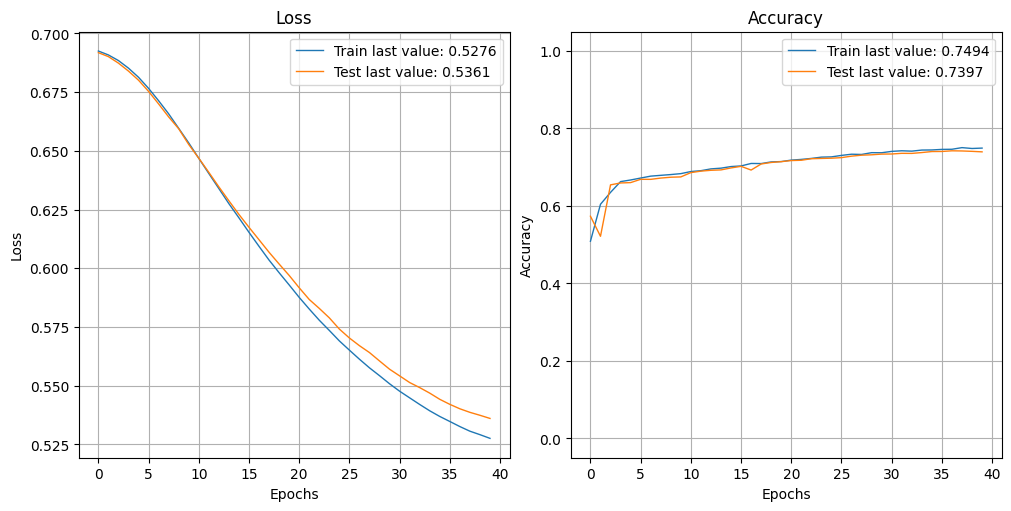

In [23]:
plot_history(history.history)
plt.show()

#Model 2: Neural averaging model using an embedding layer

Now instead of one-hot vectors, we want to use embeddings. We change our first layer in model1 to an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

In [24]:
from keras.layers import GlobalAveragePooling2D

In [25]:
EMBEDDING_SIZE = 100

input_layer = Input((MAX_SEQUENCE_LENGTH,), dtype='int32')
embed_layer = Embedding(
    VOCAB_SIZE,
    EMBEDDING_SIZE,
    name="embedding",
    embeddings_initializer="glorot_uniform",
    input_length=MAX_SEQUENCE_LENGTH,
    # mask_zero=True,
)(input_layer)
averaging_layer = GlobalAveragePooling1DMasked()(embed_layer)
hidden_layer = Dense(16)(averaging_layer)
output = Dense(1, activation="sigmoid")(hidden_layer)
model2 = Model(inputs=[input_layer], outputs=[output])
model2.summary()
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 100)          1000000   
                                                                 
 global_average_pooling1d_ma  (None, 100)              0         
 sked_1 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_2 (Dense)             (None, 16)                1616      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,001,633
Trainable params: 1,001,633
Non-tra

In [26]:
history2 = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 6s 158ms/step - loss: 0.6874 - accuracy: 0.6405 - val_loss: 0.6781 - val_accuracy: 0.6648
Epoch 2/40
30/30 [==============================] - 5s 155ms/step - loss: 0.6553 - accuracy: 0.7325 - val_loss: 0.6295 - val_accuracy: 0.7485
Epoch 3/40
30/30 [==============================] - 6s 200ms/step - loss: 0.5850 - accuracy: 0.7746 - val_loss: 0.5515 - val_accuracy: 0.7807
Epoch 4/40
30/30 [==============================] - 4s 122ms/step - loss: 0.4946 - accuracy: 0.8161 - val_loss: 0.4696 - val_accuracy: 0.8228
Epoch 5/40
30/30 [==============================] - 2s 85ms/step - loss: 0.4097 - accuracy: 0.8541 - val_loss: 0.4028 - val_accuracy: 0.8483
Epoch 6/40
30/30 [==============================] - 2s 71ms/step - loss: 0.3469 - accuracy: 0.8772 - val_loss: 0.3612 - val_accuracy: 0.8598
Epoch 7/40
30/30 [==============================] - 3s 84ms/step - loss: 0.3023 - accuracy: 0.8917 - val_loss: 0.3336 - val_accuracy: 0.8683
Epoch 8/4

In [27]:
results = model2.evaluate(X_test_enc, y_test)

782/782 [==============================] - 2s 2ms/step - loss: 0.5962 - accuracy: 0.8527


[0.5962138772010803, 0.8527200222015381]


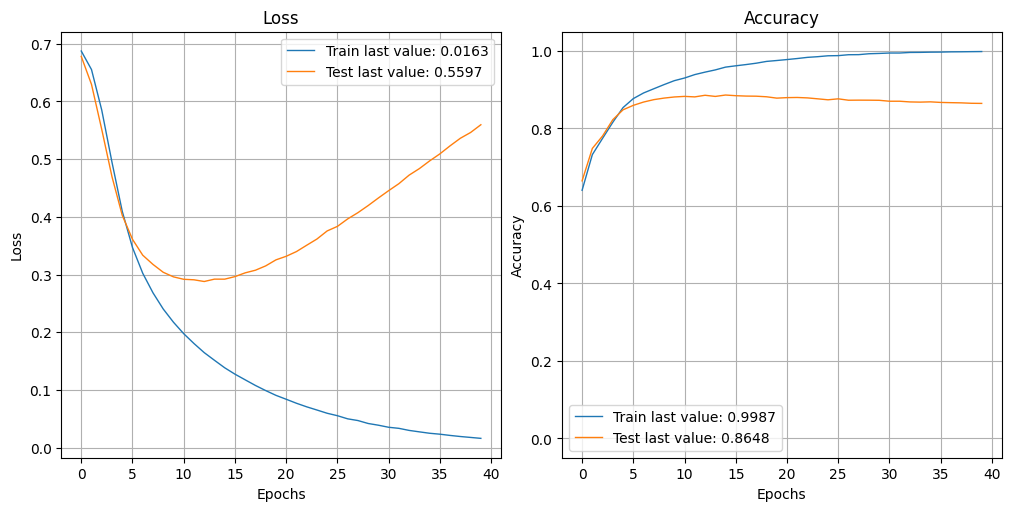

In [28]:
print (results)
plot_history(history2.history)
plt.show()

The accuracy of model2 is ~87%. Using Embedding layer instead of one-hot layer improved the performance.

# Model 3: Using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

The Embedding layer can be used to load pre-trained word embeddings. We are going to use GloVe embeddings (https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a popular embedding technique based on factorising a matrix of word co-occurence statistics. You can download GloVe and initialise the Keras Embedding layer with weights from the pre-trained embedding model for the words in your dataset.
First, we need to read GloVe and map words to GloVe:


In [29]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [30]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [31]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2023-03-09 21:14:02--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-03-09 21:14:03--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-09 21:14:03--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

We freeze the weights to create the layer: 

In [32]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)
print(embeddingLayer)

Size of Embedding:  300


## Model 3-1: Neural Network model using pre-trained word embeddings

In [33]:
input_layer = Input((MAX_SEQUENCE_LENGTH,), dtype='int32')
embed_layer = embeddingLayer(input_layer)
averaging_layer = GlobalAveragePooling1DMasked()(embed_layer)
hidden_layer = Dense(16)(averaging_layer)
output = Dense(1, activation="sigmoid")(hidden_layer)
model3 = Model(inputs=[input_layer], outputs=[output])

model3.summary()
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_2 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_4 (Dense)             (None, 16)                4816      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                           

In [34]:
history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 12ms/step - loss: 0.6884 - accuracy: 0.5403 - val_loss: 0.6826 - val_accuracy: 0.5761
Epoch 2/40
30/30 [==============================] - 0s 8ms/step - loss: 0.6776 - accuracy: 0.5873 - val_loss: 0.6741 - val_accuracy: 0.5929
Epoch 3/40
30/30 [==============================] - 0s 8ms/step - loss: 0.6693 - accuracy: 0.6014 - val_loss: 0.6665 - val_accuracy: 0.6037
Epoch 4/40
30/30 [==============================] - 0s 8ms/step - loss: 0.6611 - accuracy: 0.6157 - val_loss: 0.6584 - val_accuracy: 0.6192
Epoch 5/40
30/30 [==============================] - 0s 7ms/step - loss: 0.6531 - accuracy: 0.6317 - val_loss: 0.6506 - val_accuracy: 0.6353
Epoch 6/40
30/30 [==============================] - 0s 8ms/step - loss: 0.6454 - accuracy: 0.6456 - val_loss: 0.6432 - val_accuracy: 0.6464
Epoch 7/40
30/30 [==============================] - 0s 8ms/step - loss: 0.6366 - accuracy: 0.6574 - val_loss: 0.6359 - val_accuracy: 0.6558
Epoch 8/40
30/30 [=

782/782 [==============================] - 1s 2ms/step - loss: 0.5537 - accuracy: 0.7181
[0.553726315498352, 0.7181199789047241]


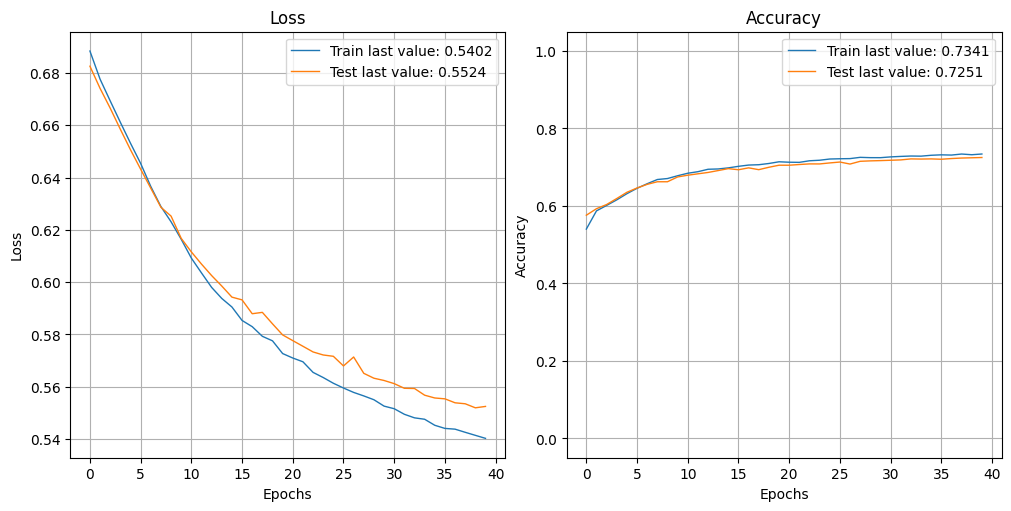

In [35]:
results = model3.evaluate(X_test_enc, y_test)
print(results)
plot_history(history3.history)
plt.show()

To compare freezing and fine-tuning the pre-trained embeding weights, we fine-tune the weights below:

In [36]:
embeddingLayer=createPretrainedEmbeddingLayer(
    wordToGlove, 
    wordToIndex, 
    isTrainable=True
    )
input_layer = Input((MAX_SEQUENCE_LENGTH,), dtype='int32')
embed_layer = embeddingLayer(input_layer)
averaging_layer = GlobalAveragePooling1DMasked()(embed_layer)
hidden_layer = Dense(16)(averaging_layer)
output = Dense(1, activation="sigmoid")(hidden_layer)
model3 = Model(inputs=[input_layer], outputs=[output])

model3.summary()
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_3 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_6 (Dense)             (None, 16)                4816      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                           

Epoch 1/40
30/30 [==============================] - 7s 193ms/step - loss: 0.6825 - accuracy: 0.5721 - val_loss: 0.6677 - val_accuracy: 0.6364
Epoch 2/40
30/30 [==============================] - 5s 172ms/step - loss: 0.6479 - accuracy: 0.6663 - val_loss: 0.6279 - val_accuracy: 0.6885
Epoch 3/40
30/30 [==============================] - 5s 152ms/step - loss: 0.5907 - accuracy: 0.7286 - val_loss: 0.5600 - val_accuracy: 0.7574
Epoch 4/40
30/30 [==============================] - 4s 117ms/step - loss: 0.5083 - accuracy: 0.7935 - val_loss: 0.4783 - val_accuracy: 0.8127
Epoch 5/40
30/30 [==============================] - 5s 154ms/step - loss: 0.4214 - accuracy: 0.8445 - val_loss: 0.4083 - val_accuracy: 0.8381
Epoch 6/40
30/30 [==============================] - 4s 139ms/step - loss: 0.3550 - accuracy: 0.8674 - val_loss: 0.3625 - val_accuracy: 0.8567
Epoch 7/40
30/30 [==============================] - 3s 116ms/step - loss: 0.3072 - accuracy: 0.8875 - val_loss: 0.3359 - val_accuracy: 0.8659
Epoch 

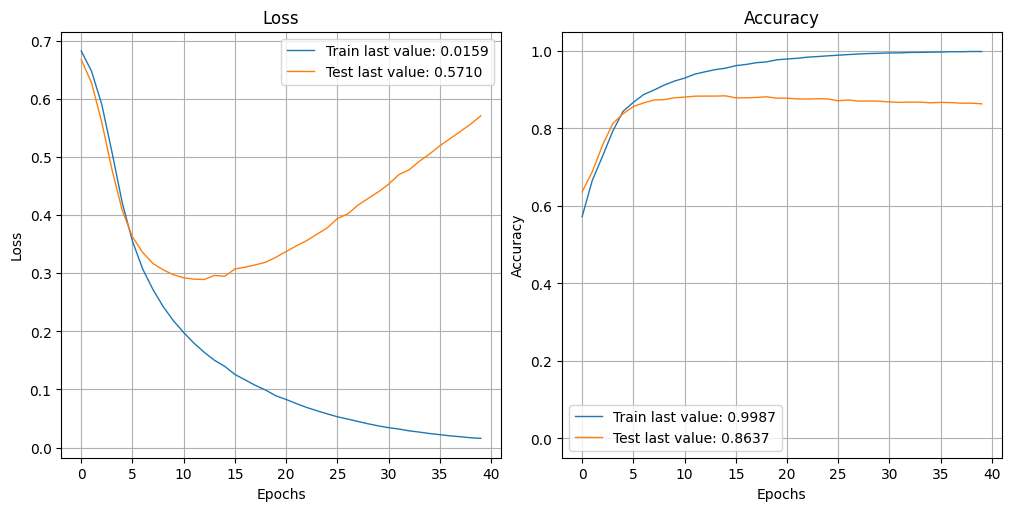

In [37]:
# Train and test the model
history3 = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
results = model3.evaluate(X_test_enc, y_test)
print(results)
plot_history(history3.history)
plt.show()

Experiments here show that fine-tuning the pre-trained embeddings would obtain better accuracy.

**Note**: Use frozen pre-trained embeddings in the subsequent experiments.

##  Model 3-2: LSTM with pre-trained word embeddings

In lab 2, we have conducted an experiment with LSTMs. Now, we replace its embeddings with the pre-trained GLOVE embeddings.

In [38]:
from keras.layers import LSTM

In [39]:
embeddingLayer=createPretrainedEmbeddingLayer(
    wordToGlove, 
    wordToIndex, 
    isTrainable=False,
    )
input_layer = Input((MAX_SEQUENCE_LENGTH,), dtype='int32')
embed_layer = embeddingLayer(input_layer)
lstm_step = LSTM(100, return_sequences=False)(embed_layer)
output = Dense(1, activation="sigmoid")(lstm_step)
model3_2 = Model(inputs=[input_layer], outputs=[output])


# label = Dense(1, activation='sigmoid')(final_lstm_step)

model3_2.summary()
model3_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 120,160,801
Trainable params: 160,501
Non-trainable params: 120,000,300
_________________________________________________________________


Epoch 1/40
30/30 [==============================] - 6s 88ms/step - loss: 0.6912 - accuracy: 0.5167 - val_loss: 0.6861 - val_accuracy: 0.5261
Epoch 2/40
30/30 [==============================] - 2s 73ms/step - loss: 0.6769 - accuracy: 0.5503 - val_loss: 0.6778 - val_accuracy: 0.5442
Epoch 3/40
30/30 [==============================] - 2s 73ms/step - loss: 0.6522 - accuracy: 0.6044 - val_loss: 0.6300 - val_accuracy: 0.6610
Epoch 4/40
30/30 [==============================] - 2s 74ms/step - loss: 0.6283 - accuracy: 0.6431 - val_loss: 0.6306 - val_accuracy: 0.6730
Epoch 5/40
30/30 [==============================] - 2s 74ms/step - loss: 0.6658 - accuracy: 0.5919 - val_loss: 0.7048 - val_accuracy: 0.5051
Epoch 6/40
30/30 [==============================] - 2s 75ms/step - loss: 0.6793 - accuracy: 0.5429 - val_loss: 0.6831 - val_accuracy: 0.5191
Epoch 7/40
30/30 [==============================] - 2s 74ms/step - loss: 0.6719 - accuracy: 0.5553 - val_loss: 0.6805 - val_accuracy: 0.5256
Epoch 8/40
30

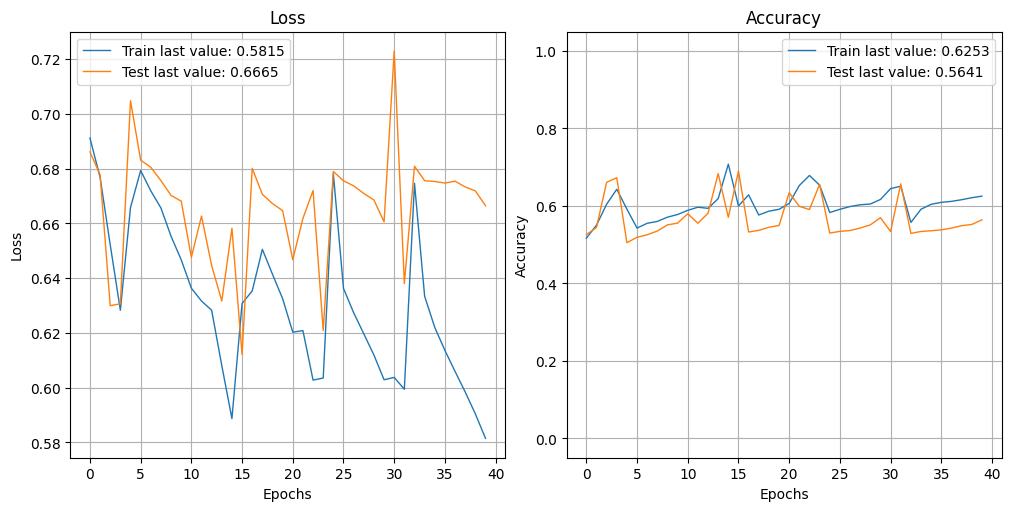

In [40]:
# Train and test the model

history3_2 = model3_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
results = model3_2.evaluate(X_test_enc, y_test)
print(results)
plot_history(history3_2.history)
plt.show()

This experiment shows that simply replacing the lab 2 model embeddings with the pre-trained word embeddings (GLOVE) will cause performance to drop significantly. What can you do to improve the situation?

#  Model 4: Adding extra dense layer into Neural Network model

We add extra dense layers into model 3-1 to evaluate their contribution. We start by adding one layer then two. All the other parameters are the same as for model 3-1.

### Adding one extra dense layer

In [41]:
# your code goes here
# Inspect model performance with 1 hidden layer, pre-trained embeddings
embeddingLayer=createPretrainedEmbeddingLayer(
    wordToGlove, 
    wordToIndex, 
    isTrainable=False,
    )
input_layer = Input((MAX_SEQUENCE_LENGTH,), dtype='int32')
embed_layer = embeddingLayer(input_layer)
averaging_layer = GlobalAveragePooling1DMasked()(embed_layer)
hidden_layer1 = Dense(100)(averaging_layer)
hidden_layer2 = Dense(16)(hidden_layer1)
output = Dense(1, activation="sigmoid")(hidden_layer2)
model4_1 = Model(inputs=[input_layer], outputs=[output])

model4_1.summary()
model4_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_4 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_9 (Dense)             (None, 100)               30100     
                                                                 
 dense_10 (Dense)            (None, 16)                1616      
                                                           

Epoch 1/40
30/30 [==============================] - 1s 13ms/step - loss: 0.6809 - accuracy: 0.5625 - val_loss: 0.6707 - val_accuracy: 0.5916
Epoch 2/40
30/30 [==============================] - 0s 8ms/step - loss: 0.6598 - accuracy: 0.6134 - val_loss: 0.6489 - val_accuracy: 0.6300
Epoch 3/40
30/30 [==============================] - 0s 8ms/step - loss: 0.6337 - accuracy: 0.6545 - val_loss: 0.6224 - val_accuracy: 0.6653
Epoch 4/40
30/30 [==============================] - 0s 8ms/step - loss: 0.6123 - accuracy: 0.6731 - val_loss: 0.6075 - val_accuracy: 0.6722
Epoch 5/40
30/30 [==============================] - 0s 8ms/step - loss: 0.5923 - accuracy: 0.6905 - val_loss: 0.5930 - val_accuracy: 0.6886
Epoch 6/40
30/30 [==============================] - 0s 8ms/step - loss: 0.5886 - accuracy: 0.6923 - val_loss: 0.5829 - val_accuracy: 0.6968
Epoch 7/40
30/30 [==============================] - 0s 8ms/step - loss: 0.5718 - accuracy: 0.7092 - val_loss: 0.5790 - val_accuracy: 0.7021
Epoch 8/40
30/30 [=

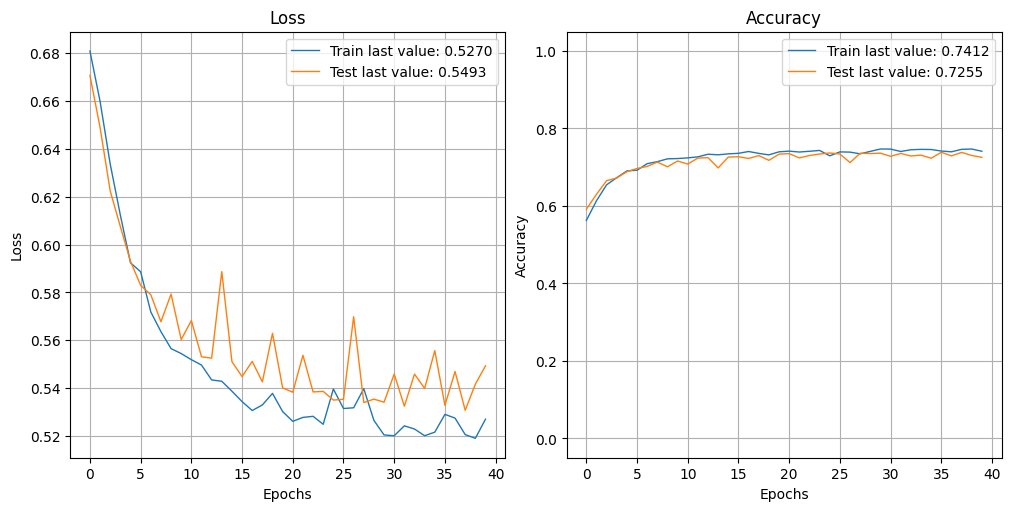

In [42]:
history4_1= model4_1.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
results = model4_1.evaluate(X_test_enc, y_test)
print(results)
plot_history(history4_1.history)
plt.show()

### Adding two extra dense layers

In [43]:
embeddingLayer=createPretrainedEmbeddingLayer(
    wordToGlove, 
    wordToIndex, 
    isTrainable=False,
    )
input_layer = Input((MAX_SEQUENCE_LENGTH,), dtype='int32')
embed_layer = embeddingLayer(input_layer)
averaging_layer = GlobalAveragePooling1DMasked()(embed_layer)
hidden_layer1 = Dense(300)(averaging_layer)
hidden_layer2 = Dense(100)(hidden_layer1)
hidden_layer3 = Dense(16)(hidden_layer2)
output = Dense(1, activation="sigmoid")(hidden_layer3)
model4_2 = Model(inputs=[input_layer], outputs=[output])

model4_2.summary()
model4_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_5 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_12 (Dense)            (None, 300)               90300     
                                                                 
 dense_13 (Dense)            (None, 100)               30100     
                                                           

Epoch 1/40
30/30 [==============================] - 2s 26ms/step - loss: 0.6864 - accuracy: 0.5559 - val_loss: 0.6699 - val_accuracy: 0.5909
Epoch 2/40
30/30 [==============================] - 0s 8ms/step - loss: 0.6474 - accuracy: 0.6341 - val_loss: 0.6237 - val_accuracy: 0.6627
Epoch 3/40
30/30 [==============================] - 0s 8ms/step - loss: 0.6049 - accuracy: 0.6775 - val_loss: 0.6204 - val_accuracy: 0.6578
Epoch 4/40
30/30 [==============================] - 0s 8ms/step - loss: 0.5909 - accuracy: 0.6902 - val_loss: 0.5791 - val_accuracy: 0.7031
Epoch 5/40
30/30 [==============================] - 0s 8ms/step - loss: 0.5650 - accuracy: 0.7140 - val_loss: 0.6053 - val_accuracy: 0.6824
Epoch 6/40
30/30 [==============================] - 0s 8ms/step - loss: 0.5634 - accuracy: 0.7115 - val_loss: 0.5836 - val_accuracy: 0.6985
Epoch 7/40
30/30 [==============================] - 0s 8ms/step - loss: 0.5626 - accuracy: 0.7116 - val_loss: 0.5533 - val_accuracy: 0.7254
Epoch 8/40
30/30 [=

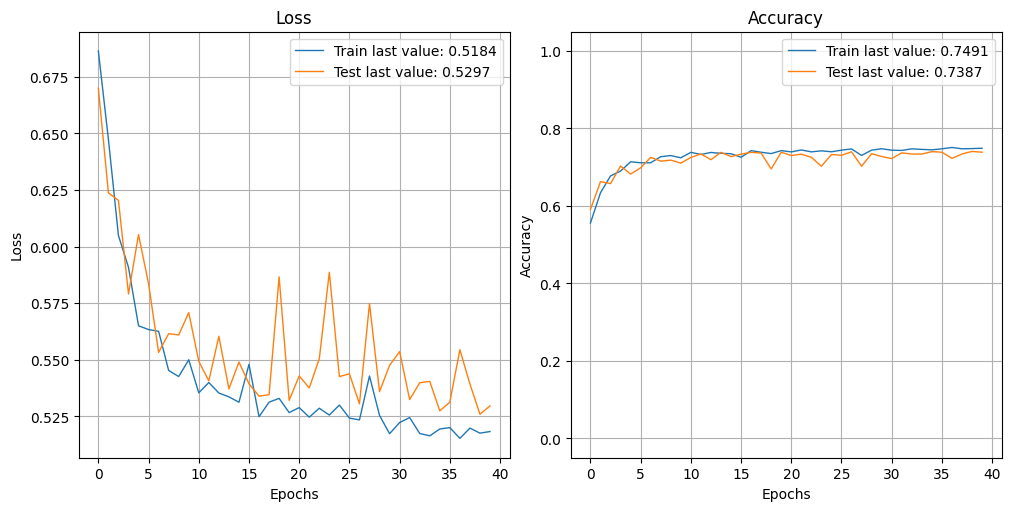

In [44]:
history4_2= model4_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
results = model4_2.evaluate(X_test_enc, y_test)
print(results)
plot_history(history4_2.history)
plt.show()

These two experiments show that adding extra dense layers can slightly improve accuracy over model 3-1.

---



#  Model 5: CNN for Text Classification

##  Model 5-1: Basic CNN model for Text Classification 

In this section, we build a Convolutional Neural Network (CNN) for text classification. We start by using one CNN layer and then adding another layer. You could use pre-trained embeddings or scratch train them from scratch.

In [49]:
from keras.layers import Conv1D, GlobalMaxPooling1D

In [52]:
EMBEDDING_SIZE = 300

input_layer = Input((MAX_SEQUENCE_LENGTH,), dtype='int32')
embed_layer = Embedding(
    VOCAB_SIZE,
    EMBEDDING_SIZE,
    name="embedding",
    embeddings_initializer="glorot_uniform",
    input_length=MAX_SEQUENCE_LENGTH,
    # mask_zero=True,
)(input_layer)
cnn_layer = Conv1D(100, 6)(embed_layer)
max_pooling_layer = GlobalMaxPooling1D()(cnn_layer)
output = Dense(1, activation="sigmoid")(max_pooling_layer)
model5_1 = Model(inputs=[input_layer], outputs=[output])
model5_1.summary()
model5_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 300)          3000000   
                                                                 
 conv1d_2 (Conv1D)           (None, 251, 100)          180100    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_20 (Dense)            (None, 1)                 101       
                                                                 
Total params: 3,180,201
Trainable params: 3,180,201
Non-trainable params: 0
________________________________________________

Train and test the model, also plot train and validation accuracy and loss over epochs.

Epoch 1/40
30/30 [==============================] - 11s 184ms/step - loss: 0.6651 - accuracy: 0.6557 - val_loss: 0.5955 - val_accuracy: 0.7791
Epoch 2/40
30/30 [==============================] - 4s 149ms/step - loss: 0.4679 - accuracy: 0.8231 - val_loss: 0.3695 - val_accuracy: 0.8442
Epoch 3/40
30/30 [==============================] - 4s 136ms/step - loss: 0.2796 - accuracy: 0.8944 - val_loss: 0.3082 - val_accuracy: 0.8679
Epoch 4/40
30/30 [==============================] - 4s 150ms/step - loss: 0.1760 - accuracy: 0.9416 - val_loss: 0.3069 - val_accuracy: 0.8711
Epoch 5/40
30/30 [==============================] - 4s 136ms/step - loss: 0.1074 - accuracy: 0.9701 - val_loss: 0.3232 - val_accuracy: 0.8673
Epoch 6/40
30/30 [==============================] - 4s 128ms/step - loss: 0.0608 - accuracy: 0.9878 - val_loss: 0.3494 - val_accuracy: 0.8646
Epoch 7/40
30/30 [==============================] - 4s 117ms/step - loss: 0.0333 - accuracy: 0.9963 - val_loss: 0.3772 - val_accuracy: 0.8640
Epoch

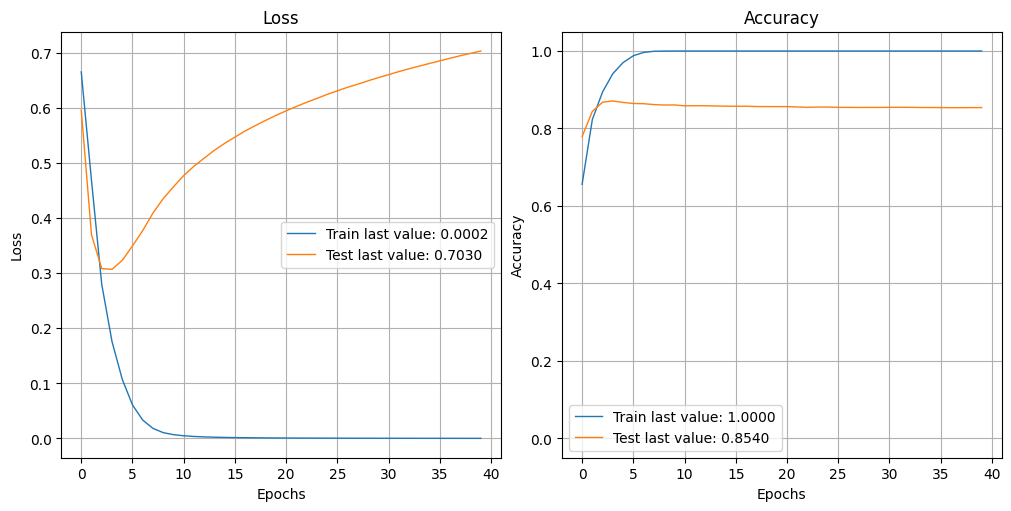

In [53]:
# your code goes here
history5_1= model5_1.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
results = model5_1.evaluate(X_test_enc, y_test)
print(results)
plot_history(history5_1.history)
plt.show()
 

## Model 5-2: Adding extra convolutional layer

In [54]:
EMBEDDING_SIZE = 300

input_layer = Input((MAX_SEQUENCE_LENGTH,), dtype='int32')
embed_layer = Embedding(
    VOCAB_SIZE,
    EMBEDDING_SIZE,
    name="embedding",
    embeddings_initializer="glorot_uniform",
    input_length=MAX_SEQUENCE_LENGTH,
    # mask_zero=True,
)(input_layer)
cnn_layer1 = Conv1D(100, 6)(embed_layer)
cnn_layer2 = Conv1D(100, 6)(cnn_layer1)
max_pooling_layer = GlobalMaxPooling1D()(cnn_layer2)
output = Dense(1, activation="sigmoid")(max_pooling_layer)
model5_2 = Model(inputs=[input_layer], outputs=[output])
model5_2.summary()
model5_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256)]             0         
                                                                 
 embedding (Embedding)       (None, 256, 300)          3000000   
                                                                 
 conv1d_3 (Conv1D)           (None, 251, 100)          180100    
                                                                 
 conv1d_4 (Conv1D)           (None, 246, 100)          60100     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_21 (Dense)            (None, 1)                 101       
                                                          

Train and test the model, also plot train and validation accuracy and loss over epochs.

Epoch 1/40
30/30 [==============================] - 6s 136ms/step - loss: 0.6210 - accuracy: 0.6451 - val_loss: 0.4479 - val_accuracy: 0.7991
Epoch 2/40
30/30 [==============================] - 4s 126ms/step - loss: 0.3515 - accuracy: 0.8501 - val_loss: 0.3624 - val_accuracy: 0.8396
Epoch 3/40
30/30 [==============================] - 4s 118ms/step - loss: 0.2110 - accuracy: 0.9215 - val_loss: 0.3895 - val_accuracy: 0.8441
Epoch 4/40
30/30 [==============================] - 4s 122ms/step - loss: 0.1205 - accuracy: 0.9582 - val_loss: 0.4616 - val_accuracy: 0.8382
Epoch 5/40
30/30 [==============================] - 4s 117ms/step - loss: 0.0590 - accuracy: 0.9821 - val_loss: 0.5768 - val_accuracy: 0.8333
Epoch 6/40
30/30 [==============================] - 4s 122ms/step - loss: 0.0286 - accuracy: 0.9926 - val_loss: 0.6863 - val_accuracy: 0.8316
Epoch 7/40
30/30 [==============================] - 3s 118ms/step - loss: 0.0145 - accuracy: 0.9969 - val_loss: 0.7600 - val_accuracy: 0.8334
Epoch 

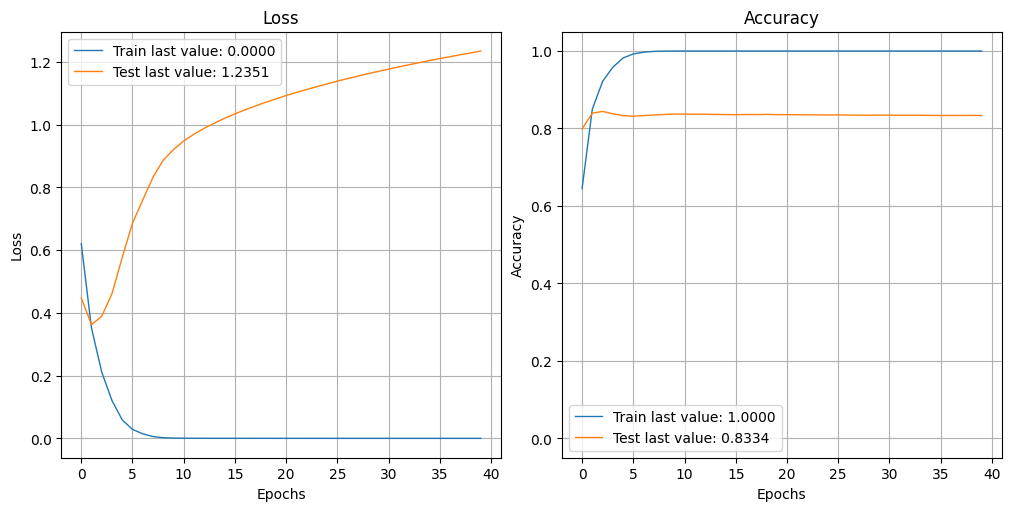

In [55]:
# your code goes here
# Train and test the model
history5_2= model5_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)
results = model5_2.evaluate(X_test_enc, y_test)
print(results)
plot_history(history5_2.history)
plt.show()

Although adding a layer here reduces the training loss, the evaluation accuracy is worse than for the model without the extra convolutional layer.

 Adding more layers can help you to extract more features. But we can do that up to a certain extent. After some point, instead of extracting features, we tend to overfit. Overfitting can lead to errors, such as false positives. It is not easy to choose the number of units in a hidden layer or the number of hidden layers in a neural network. For many applications, one hidden layer is enough. As a general rule, the number of units in this hidden layer is between the number of network input dimensions and the number of output dimensions.
 The best way to decide on the number of units and hidden layers is to try various parameters. Train several neural networks with different numbers of hidden layers and neurons, and monitor their performance.







---

